### Face Detection

Face detection is a crucial step for many applications, especially for personal identification and access control. In this notebook, we are going to demonstrate the use of several tool, namely:
* Viola-Jones object detector (applied to faces)
* concept of facial landmarks
* dlib library
* face alignment

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

ImportError: DLL load failed while importing cv2: The specified module could not be found.

We are going to load the Viola-Jones detector based on Haar cascades. The detector, already trained for detecting faces, is part of opencv contrib distribution and is located in its data subfolder.

In [ ]:
casc_path = './data/haarcascades/haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(casc_path)

In [ ]:
img = cv2.imread('./data/zelensky.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
plt.imshow(img_rgb)
gray[100][100]

### Viola-Jones

Viola-Jones is a classic and powerful algorithm for object detection. It is a sliding window approach that work in cascades and exploits Haar transform (basis functions) to learn object descriptors. It also makes uso of boosting.

In [ ]:
# minNeighbors = 0 shows all the detection at all scale, a value of approx. 5 shall felter out all the spurious detections
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, flags=cv2.CASCADE_SCALE_IMAGE)

print('Number of detected faces:', len(faces))

# Draw rectangle around each face
result = np.copy(img_rgb)
faces_img = []
for (x, y, w, h) in faces: 
    # Draw rectangle around the face
    cv2.rectangle(result, (x, y), (x+w, y+h), (0, 255, 0), 3)
    faces_img.append(img_rgb[y:y+h, x:x+w, :])
    
plt.imshow(result)

In [ ]:
plt.subplot(121), plt.imshow(result, cmap='gray')
plt.subplot(122), plt.imshow(faces_img[0])

### Face Detection via dlib

Dlib is a general purpose cross-platform software library that contains many useful tools. In particular, it includes a trained DNN for face detection.

In [2]:
import dlib
# Let's load the detector
detector = dlib.get_frontal_face_detector()
# Detect faces, see http://dlib.net/face_detector.py.html
# 1 --> upsampling factor
rects = detector(img_rgb, 1)

print('Number of detected faces:', len(rects))
print(rects)
print(rects[0].left)

def rect_to_bb(rect):
    # Dlib rect --> OpenCV rect
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y

    return (x, y, w, h)


# Draw rectangle around each face
result_dlib = np.copy(img_rgb)
faces_dlib_img = []
for rect in rects:    
    # Draw rectangle around the face
    x, y, w, h = rect_to_bb(rect)
    print(x, y, w, h)
    cv2.rectangle(result_dlib, (x, y), (x+w, y+h), (0, 255, 0), 3)
    faces_dlib_img.append(img_rgb[y:y+h, x:x+w, :])
    
print(len(faces_dlib_img))
plt.subplot(121), plt.imshow(result), plt.title('Viola-Jones')
plt.subplot(122), plt.imshow(result_dlib), plt.title('dlib')

NameError: name 'img_rgb' is not defined

### Facial Landmarks

Facial landmarks can be considred as keypoints that define the contours of a face, eyes, nose and mouth. There are many models for facial landmarking, one of the most popular is the 68-point model (https://link.springer.com/article/10.1007/s11554-021-01107-w)

In [74]:
# Load the predictor (you need to download the predictor from an available source)
predictor = dlib.shape_predictor('./data/Datasets/shape_predictor_68_face_landmarks.dat')


face = faces_dlib_img[0]
rows, cols, _ = face.shape
rect = dlib.rectangle(0, 0, cols, rows)
shape = predictor(cv2.cvtColor(face, cv2.COLOR_RGB2GRAY), rect)

In [76]:
def plot_landmarks(vec):
    plt.plot(vec[0:17,0], vec[0:17,1], 'g.-')       # Contour
    plt.plot(vec[48:68,0], vec[48:68,1], 'g.-')     # Mouth
    plt.plot(vec[17:22,0], vec[17:22,1], 'g.-')     # Right eyebrow
    plt.plot(vec[22:27,0], vec[22:27,1], 'g.-')     # Left eyebrow
    plt.plot(np.concatenate((vec[36:42,0], vec[36:37,0])), np.concatenate((vec[36:42,1], vec[36:37,1])), 'g.-')     # Left eye
    plt.plot(np.concatenate((vec[42:48,0], vec[42:43,0])), np.concatenate((vec[42:48,1], vec[42:43,1])), 'g.-')     # Right eye
    plt.plot(vec[27:36,0], vec[27:36,1], 'g.-')     # Nose

In [78]:
# Convert landmarks to ndarray for better manipulation
kps = list(map(lambda p: (p.x, p.y), shape.parts()))
landmarks = np.array(kps)
print(kps)

[(34, 57), (33, 81), (34, 105), (36, 128), (41, 150), (51, 172), (65, 190), (81, 209), (100, 217), (123, 217), (148, 204), (172, 188), (191, 170), (205, 149), (214, 124), (220, 97), (224, 71), (43, 48), (51, 36), (68, 35), (83, 41), (97, 52), (124, 55), (143, 49), (163, 49), (181, 57), (193, 71), (109, 74), (106, 92), (103, 111), (99, 129), (82, 130), (89, 136), (100, 142), (111, 138), (122, 134), (60, 68), (69, 64), (81, 67), (90, 75), (78, 77), (66, 75), (135, 81), (146, 76), (159, 78), (169, 84), (159, 88), (146, 86), (70, 156), (81, 156), (90, 156), (99, 159), (108, 158), (120, 162), (136, 166), (119, 174), (107, 176), (97, 175), (88, 173), (80, 168), (75, 158), (90, 161), (99, 164), (108, 163), (130, 165), (107, 166), (98, 166), (89, 163)]


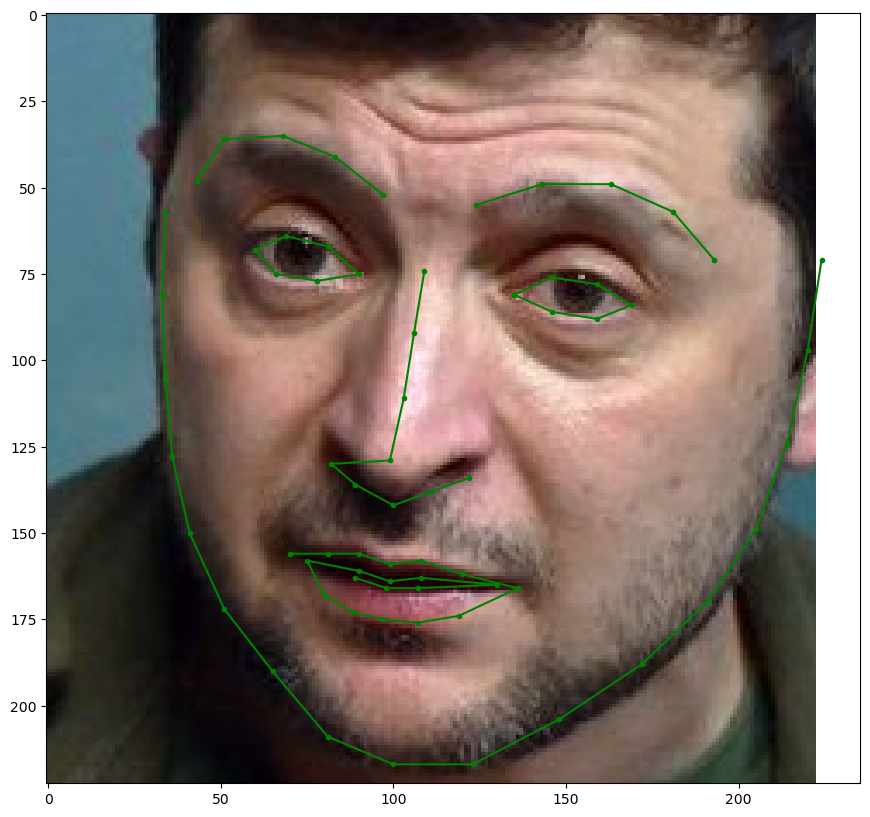

In [80]:
plt.imshow(face)
plot_landmarks(landmarks)

### Face Alignment

Face alignment is an important pre-processing step for face identification. The goal is to transform the detected faces as it was taken in frontal view. In general, only affine transforms are considered so the facial proportions are maintained.

(-0.05, 1.05, -1.05, 0.050000000000000044)

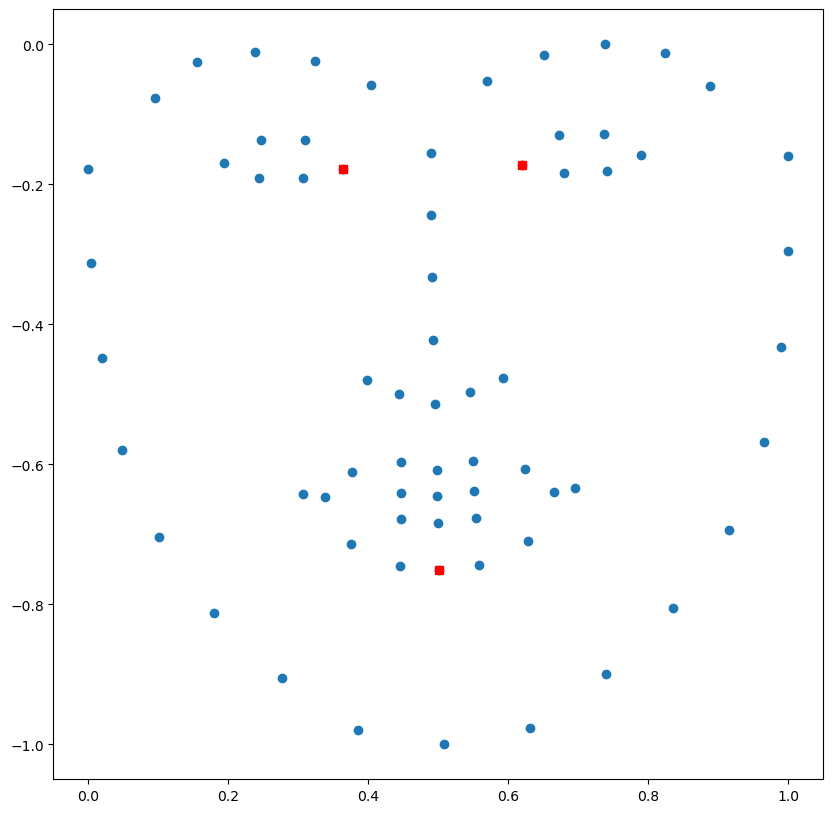

In [83]:
face_template = np.load('data/face_template.npy')

tpl_min, tpl_max = np.min(face_template, axis=0), np.max(face_template, axis=0)
face_template = (face_template - tpl_min) / (tpl_max - tpl_min)

plt.plot(face_template[:, 0], -face_template[:, 1], 'o')

inner_triangle = [39, 42, 57]
plt.plot(face_template[inner_triangle, 0], -face_template[inner_triangle, 1], 'rs')

plt.axis('square')

(<Axes: title={'center': 'Aligned'}>,
 Text(0.5, 1.0, 'Aligned'))

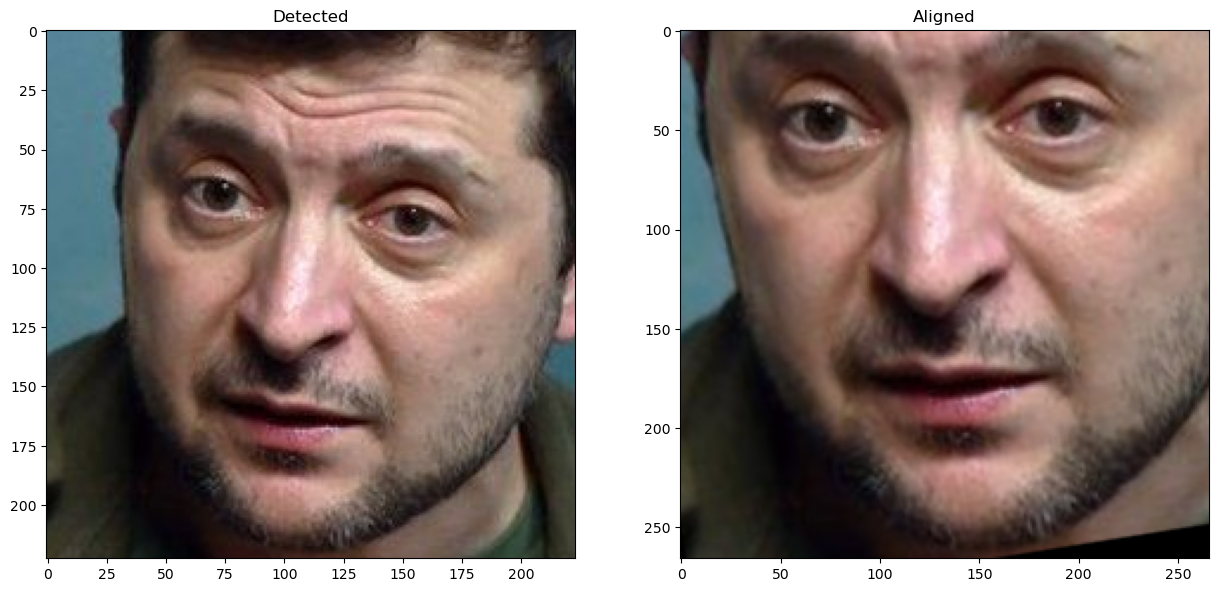

In [85]:
out_size = 256
margin = 10
out = np.copy(face)

# Prepare landmarks
landmarks = np.float32(landmarks)
landmarks_idx = np.array(inner_triangle)

# Adjust template (adjust to size, to margin and normalize back)
template = face_template * out_size
template = template + (margin/2)
template = template / (out_size + margin)

# Estimate affine transform
H = cv2.getAffineTransform(landmarks[landmarks_idx], (out_size + margin) * template[landmarks_idx])

# Rectify final image
aligned = cv2.warpAffine(out, H, (out_size + margin, out_size + margin))

plt.subplot(121), plt.imshow(face), plt.title('Detected')
plt.subplot(122), plt.imshow(aligned), plt.title('Aligned')